In [1]:
import random
from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np
import sys
import os

In [2]:
sys.path.append(os.path.abspath(".."))

In [3]:
path = "../saved/filename_to_nonXposition.pkl"
with open(path, "rb") as f:
    filename_to_nonXposition = pickle.load(f)

# ESM-2 (650M) here as an example

In [ ]:
import torch
import esm

In [ ]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

In [6]:
path = "../saved/RemoteFoldSet_domain_to_seqs.pkl"
with open(path, "rb") as f:
    domain_to_seqs = pickle.load(f)

In [7]:
data = []
for domain, sampled_seqs in domain_to_seqs.items():
    count = 0
    for seq in sampled_seqs:
        count += 1
        data.append((domain + "_" + str(count), seq.replace("X", "-")))

In [8]:
len(data), data[:2]

(1440,
 [('3p5pa02_1',
   'YRHWGATASVALLERLWNTGNRMPQYPSALSWVAATMKKDGSWGIWTKPYLWSRLRDTLSAAIALAKWQCAATETQKAIHWVNSEIQRMHSVSKRQPWFKVYLPKLFTEAVGLGLELPYDDAYIQNIIHERAEGLKERQENPEGLTQDQQPGIDGYTDVIDWKNVLRPRKPDGSFDPGLGPTATIYASTEDPRAGEYIKRHL'),
  ('3p5pa02_2',
   'KPDMYQQSEVAKLVRDDEPGSAAPLYESALAYVAKNQLDDGTWGDKENPQLSKQLKATSASILALKNFNTNEINLELGEKYFNKELHALNEDTPLIPCMDLLWNFLCDQLLKASIKFPYDLPFVKRLQEQMSTTLRAVASCESGMPEQMLSARGCMYYVLNLDKIQCFRESNGSYKGDSGATAHLLKMTSDEKAMEWLASKL')])

In [9]:
name_list = []
seq_list = []
sequence_rep_dict = {layer_num: [] for layer_num in range(1, 34)}

for item in tqdm(data):
    batch_labels, batch_strs, batch_tokens = batch_converter([item])
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=list(range(1, 34)), return_contacts=False)

    for i, tokens_len in enumerate(batch_lens):
        name_list.append(item[0])
        seq_list.append(item[1])

        for layer_num in range(1, 34):
            token_representations = results["representations"][layer_num]
            residue_representation = token_representations[i, 1 : tokens_len - 1]
            positions = filename_to_nonXposition[batch_labels[i]]
            sequence_representation = residue_representation[positions].mean(0)
            sequence_rep_dict[layer_num].append(sequence_representation)


100%|██████████| 1440/1440 [06:05<00:00,  3.94it/s]


In [10]:
for layer_num in sequence_rep_dict:
    sequence_rep_dict[layer_num] = [t.cpu().numpy() for t in sequence_rep_dict[layer_num]]

In [11]:
records = []
for i in range(len(name_list)):
    row = {"name": name_list[i], "seq": seq_list[i]}
    for layer_num in range(1, 34):
        row[f"emb_{layer_num}"] = sequence_rep_dict[layer_num][i]
    records.append(row)

esm2_df = pd.DataFrame(records)

In [12]:
esm2_df.head()

,name,seq,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33
0,3p5pa02_1,YRHWGATASVALLERLWNTGNRMPQYPSALSWVAATMKKDGSWGIW...,"[1.3509593, -0.84548056, 1.1061571, 0.15244864...","[1.1134617, -0.21366103, 1.4463197, 0.32819667...","[0.48711452, 0.25767055, 0.5075323, 0.02745875...","[0.36637554, 0.17492042, 0.0742668, 0.09157348...","[0.2757627, -0.024074106, 0.041308805, -0.4611...","[0.015552868, 0.23072244, -0.022575755, 0.0175...","[0.7243989, 0.30490047, -0.26318884, -0.177395...","[0.03967767, 0.75944656, 0.5431425, 0.16661604...",...,"[-0.79309046, -0.2750336, -3.3926308, -1.55301...","[0.5230889, 0.23952152, -1.7148645, -2.0420485...","[1.0104206, 0.84393114, -0.832697, -3.548954, ...","[1.2729102, 0.3929648, -1.1197239, -2.2586114,...","[1.7471092, 1.9826492, -1.0147027, -1.3772125,...","[3.6981754, 2.1722443, -1.3637068, -1.3075058,...","[2.9105985, 2.032688, -1.0510584, -1.8032929, ...","[1.7505517, 1.6613717, -0.11343924, 0.12709185...","[2.680479, 2.3092232, -2.2298, 0.20342775, 0.5...","[0.032695007, 0.055693127, -0.04176947, -0.014..."
1,3p5pa02_2,KPDMYQQSEVAKLVRDDEPGSAAPLYESALAYVAKNQLDDGTWGDK...,"[0.91301155, -1.1462946, 0.9463418, 0.46008018...","[0.8449627, -0.47676805, 1.3847682, 0.6037948,...","[0.2699167, -0.010254184, 0.84489137, 0.293161...","[-0.03490297, 0.09600409, 0.7554857, 0.1061654...","[-0.0055977567, 0.049910564, 0.70074487, -0.39...","[-0.2321921, 0.039683677, 0.61051023, -0.16816...","[0.1437137, 0.3835227, -0.09733137, -0.0093191...","[-0.4232807, 0.73555577, 0.6888176, 0.23872681...",...,"[-2.1562796, -2.634278, -4.0033484, -1.6463634...","[-0.43187192, -2.0135884, -2.4569678, -1.67992...","[0.22656885, -0.9006742, -1.6960387, -3.089332...","[0.30188105, -1.8737301, -1.4582326, -1.906351...","[1.1962396, 0.13494249, -1.2945833, -0.8002687...","[2.3293993, 0.060304943, -1.4562424, -0.627061...","[2.0703943, 0.32480815, -0.31091893, -0.728911...","[2.8536775, -0.21762341, 1.8881615, 1.0002041,...","[2.9287608, -1.5065581, 1.2445095, 1.6067387, ...","[0.037656676, 0.035110418, 0.013623741, 0.0438..."
2,3p5pa02_3,SMDPFSKAYIALLVKQNSKGLLEPLFPGEVEWVKDHVQDNGYWGKS...,"[1.075005, -1.1057826, 1.0138873, 0.49687853, ...","[0.82612616, -0.44901106, 1.4886085, 0.6040473...","[0.37243938, -0.04467516, 0.80793065, 0.358437...","[0.08376541, -0.22152162, 0.84360325, 0.450997...","[0.18829896, -0.096391335, 0.6657331, -0.10684...","[-0.73415816, 0.11713349, 0.85912997, -0.00469...","[0.14103992, 0.40992823, -0.039121043, -0.2384...","[-0.59534866, 0.8002678, 0.58272815, 0.0936625...",...,"[-2.3741825, -3.3976884, -4.054347, -1.7435579...","[-0.3545984, -2.9338686, -2.6783292, -1.471749...","[0.69731504, -1.8200864, -2.1178513, -2.843509...","[0.4623797, -3.3914711, -1.8155128, -1.9642463...","[1.3536607, -1.2440696, -1.2861828, -1.0861712...","[0.983228, -1.7115362, -1.4410135, -0.77063274...","[1.5732908, -2.1908267, -0.06376372, -1.430382...","[2.3583364, -1.6924152, 0.44833148, 0.7473255,...","[1.7935447, -3.0637734, 0.39566892, 0.5389768,...","[0.019053647, 0.028450655, -0.028675307, 0.005..."
3,3p5pa02_4,CYSPVGLRFIAEMTKTTANGEDTPAFPSALLAVMNSTLVDGSYGKA...,"[1.269951, -1.1637611, 1.0396107, 0.50116134, ...","[1.0880429, -0.56480706, 1.5472075, 0.7201728,...","[0.5367989, -0.16544013, 0.58196366, 0.2877079...","[0.19890751, -0.06777803, 0.26633796, 0.372041...","[0.10007889, 0.04032008, 0.2217434, -0.2501790...","[0.2256298, 0.07157901, -0.03850624, -0.351949...","[0.6018208, -0.030800423, -0.20753649, 0.04588...","[-0.004991995, -0.22005928, 0.5390461, 0.51973...",...,"[1.5765083, -1.2770779, -2.8869174, 2.7639043,...","[2.1000466, -1.3019961, -0.89713377, 1.3309774...","[2.3416135, -2.0131936, -0.55981594, 0.4150209...","[1.7206873, -1.1850636, -1.9081925, -0.3208336...","[2.044561, 0.03438069, -0.86225384, -0.4199543...","[3.9378161, -0.24437176, -1.7397828, -1.247950...","[2.96298, -0.3920272, -2.455356, -2.30073, 1.6...","[2.8210673, -1.

In [13]:
from metrics.sa_score import group_sa_score

In [14]:
def calculate_score(sequence_representations, group_size=16):
    shuffled_list = sequence_representations.copy()
    np.random.shuffle(shuffled_list)
    embeddings = np.array(sequence_representations)
    mean_vector = np.mean(embeddings, axis=0)
    centered_embeddings = embeddings - mean_vector
    homogeneity = group_sa_score(centered_embeddings)
    return homogeneity

In [15]:
esm2_df = esm2_df.sort_values(by="name").reset_index(drop=True)
domain_names = []
for name in list(esm2_df['name']):
    domain_name = name.split("_")[0]
    if domain_name not in domain_names:
        domain_names.append(domain_name)
layerwise_scores = {}
for layer_num in range(1, 34):
    sequence_representations = esm2_df[f"emb_{layer_num}"].tolist()
    layerwise_scores[layer_num] = calculate_score(sequence_representations, group_size=16)

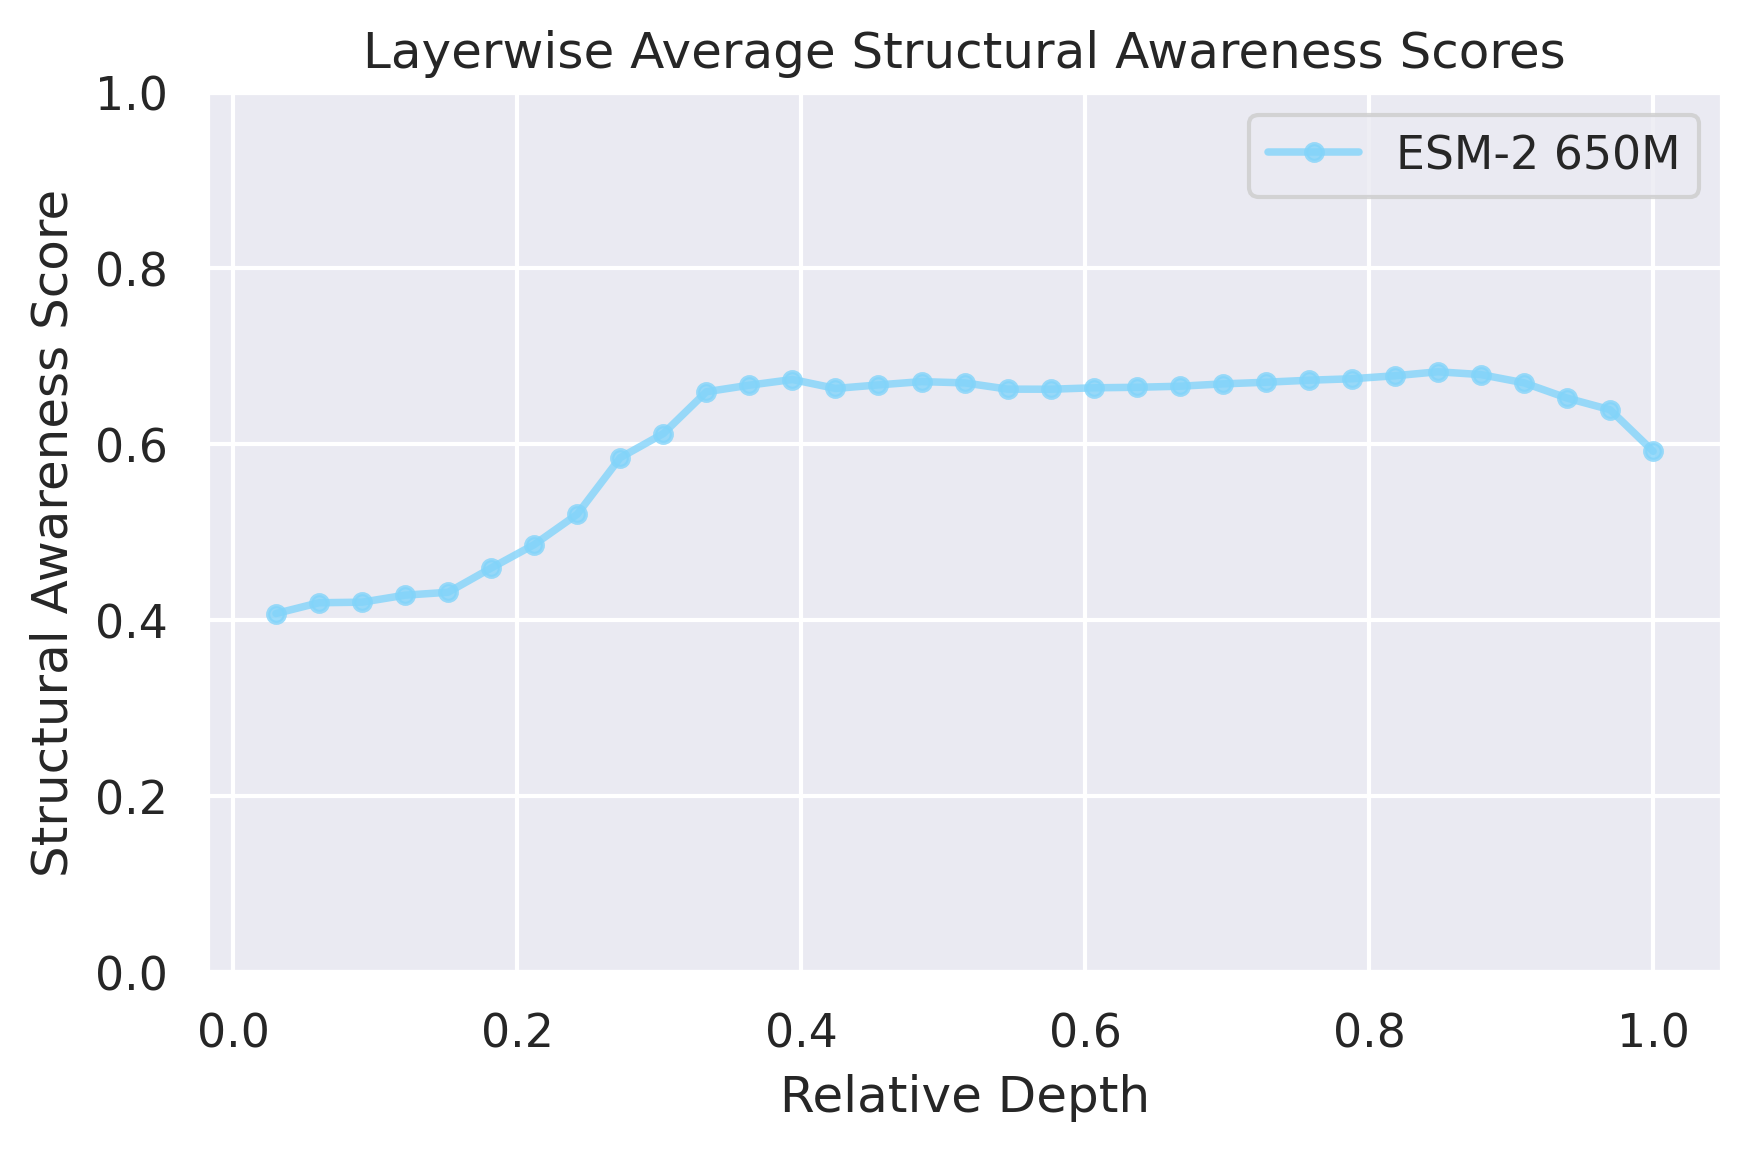

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(6, 4), dpi=300)

layers_650M = sorted(layerwise_scores.keys())
mean_650M_scores = [np.mean(layerwise_scores[layer]) for layer in layers_650M]
relative_650M = [l / max(layers_650M) for l in layers_650M]
plt.plot(relative_650M, mean_650M_scores, '-o', label="ESM-2 650M", alpha=0.8, markersize=4, color="#82D4FA", linewidth=1.8)

plt.title("Layerwise Average Structural Awareness Scores")
plt.xlabel("Relative Depth")
plt.ylabel("Structural Awareness Score")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()